Imports

In [ ]:
import re
import collections
import os
from argparse import Namespace

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.cluster import MiniBatchKMeans
from sklearn import preprocessing

import gensim.corpora as corpora
from gensim.models import LdaMulticore
from gensim.models import Word2Vec 

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader

Data loading

In [ ]:
data = pd.read_csv('dataset/data.csv', encoding='utf-8')
data.head()

,title,topic,date,text
0,Чаллыда яшәүче мөмкинлекләре чикле кешеләр күр...,society,25-11-2020,"(Казан, 25 ноябрь, «Татар-информ», «Шәһри Чалл..."
1,Актанышта бушлай дарулар бирә башладылар,health,25-11-2020,"(Казан, 25 ноябрь, «Татар-информ», «Актаныш»)...."
2,Шәле балалар бакчасында татарча курчак спектак...,science,25-11-2020,"(Казан, 25 ноябрь, «Татар-информ», Гөлнар Гари..."
3,Татарстанның җиде зур шәһәрендә бер атна эченд...,society,25-11-2020,"(Казан, 25 ноябрь,«Татар-информ»). Ноябрь дәва..."
4,"Татарстанда болытлы һава торышы, кар һәм бозла...",ecology,25-11-2020,"(Казан, 25 ноябрь, «Татар-информ»). 26 ноябрьд..."


## Data preprocessing

In [ ]:
data.describe()

,title,topic,date,text
count,62237,62237,62237,62237
unique,61605,19,1098,62215
top,Татарстан синоптиклары көчле җил турында кисәтә,society,18-03-2018,"(Азнакай, 21 октябрь, «Татар-информ», «Маяк», ..."
freq,23,19589,215,2


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62237 entries, 0 to 62236
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   62237 non-null  object
 1   topic   62237 non-null  object
 2   date    62237 non-null  object
 3   text    62237 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [ ]:
data['text'] = data['text'].apply(lambda x: x[x.index(')')+3:] if x.startswith("(") and ")" in x else x)
data['text'] = data['text'].apply(lambda x: x.replace("\r", '').replace("\n", ''))
data.head()

,title,topic,date,text
0,Чаллыда яшәүче мөмкинлекләре чикле кешеләр күр...,society,25-11-2020,Чаллының 67 нче мәктәбендә ТАССРның 100 еллыгы...
1,Актанышта бушлай дарулар бирә башладылар,health,25-11-2020,Актаныш район үзәге һәм авылларда коронавирус ...
2,Шәле балалар бакчасында татарча курчак спектак...,science,25-11-2020,Питрәч районы Шәле балалар бакчасында татарча ...
3,Татарстанның җиде зур шәһәрендә бер атна эченд...,society,25-11-2020,Ноябрь дәвамында Татарстанның моношәһәрләрендә...
4,"Татарстанда болытлы һава торышы, кар һәм бозла...",ecology,25-11-2020,"26 ноябрьдә республикада кар явуы көтелә, юлла..."


In [ ]:
data[data.duplicated()]

,title,topic,date,text
57,Татарстан Дәүләт җыр һәм бию ансамбле Россия ш...,culture,25-11-2020,Татарстан Республикасының Дәүләт җыр һәм бию а...
451,Биектау районы фермерларына кош гриппын кисәтү...,agriculture,18-11-2020,Биектау ветеринария берләшмәсе ветеринары Лили...
1876,Азнакайда яшәүче 15 гаилә фатирга сертификатла...,society,21-10-2020,Азнакай республикада төрле категория гражданна...
2132,Татарстан юлында «Газель» шоферы руль артында ...,incident,16-10-2020,Татарстан трассасында «Газель» шоферы руль арт...
2677,Чаллыда пациентның аортасы өзелүдән саклап кал...,health,06-10-2020,аллыда Ашыгыч медицина ярдәме хастаханәсендә а...
3047,Балаларга 10 мең сум пособиегә гариза язу өчен...,society,29-09-2020,Россия Президентының указлары нигезендә 3 яшьк...
5346,Саба районында яшәүче хатынның алимент буенча ...,incident,22-08-2020,Саба районында яшәүче 34 яшьлек хатынның балал...
10276,Кытайның 45 абитуриенты Казан федераль универс...,science,15-05-2020,Кытай шәһәрләре мәктәпләрендә дистанцион рәвеш...
12322,«Кардәш каләмнәр» төрки дөнья журналының яңа с...,tatar_world,05-04-2020,Анкарада нәшер ителүче төрки дөньяның әдәбият ...
12325,Роспотребнадзор: Яңа коронавирус 96 процент оч...,health,05-04-2020,96 процент очракта Cоvid-19 коронавирус инфекц...


In [ ]:
data = data.drop_duplicates().reset_index(drop=True)
data[data.duplicated()]

,title,topic,date,text


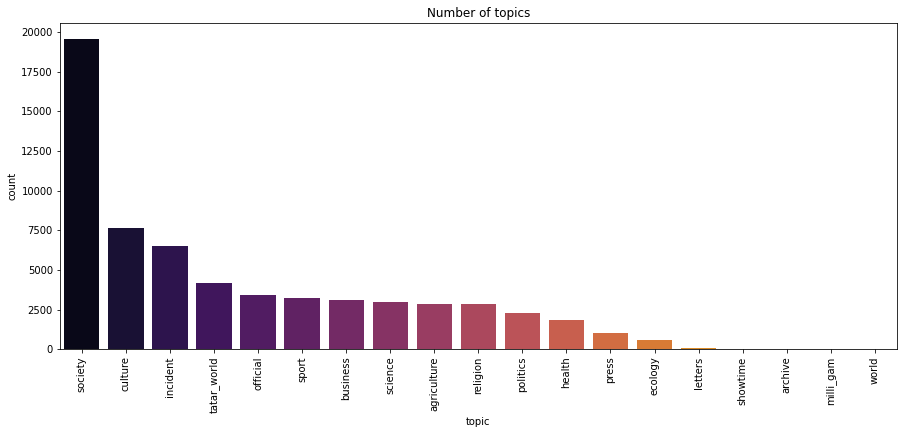

In [ ]:
plt.subplots(figsize=(15,6))
sns.countplot(x='topic', data=data, palette='inferno',
              order=data['topic'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Number of topics')
plt.show()

In [ ]:
selected_topics = ['culture', 'incident', 'sport', 'agriculture', 'religion']

In [ ]:
data = data[data['topic'].isin(selected_topics)]
data.reset_index(drop=True, inplace=True)

In [ ]:
stops = set(pd.read_csv('dataset/stopwords_tt.csv',
                        encoding='utf-8',
                        names=["words"])['words'].tolist())

In [ ]:
def reduce_affix(text, affixes,to='_'):
    regex = '|'.join(affixes)
    regex = f'({regex})'
    regex = regex+r'\b'
    
    reduced = re.sub(regex, to, text)
    return reduced

figil_shart_barlik_affix = 'сам саң са сак сагыз салар'.split()
figil_shart_yuklik_affix = ['ма'+a for a in figil_shart_barlik_affix ]
figil_past_definite_affix = 'дым дем дың дең ды де дык дек дылар деләр дыгыз дегез'.split()
figil_past_indefinite_affix = 'ганмын гәнмен ганбыз гәнбез гансың гәнсең гансыз гәнсез ган гән ганнар гәннәр'.split()
figil_present_affix = 'на нә м мын мен быз без сың сең сыз сез лар ләр нәр нәр'.split()
figil_future_affix = 'ыр ер ар әр'

ravesh_affix = 'ып еп'.split()

kilesh = ['']+'ның нең га гә ка кә ны не дан дән тан тән да дә та тә'.split()
tartim = ['']+'ен ым ем ың ең ы е м ң сы се ыбыз ебез ыгыз егез быз без гыз гез'.split()
san = ['']+'лар ләр нар нәр'.split()

comparative_affix = 'рак рәк'.split()
tartim_siyfat = 'гы ге'.split()


def preprocess_text(text):
    """Text preprocessing regular expression"""
    #text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^аәбвгдеёжҗзийклмнңоөпрстуүфхһцчшщъыьэюяa-zA-Z]+", r" ", text)

    text = reduce_affix(text, ravesh_affix)

    text = reduce_affix(text, comparative_affix)
    text = reduce_affix(text, tartim_siyfat)

    text = reduce_affix(text, kilesh, to=' ')
    text = reduce_affix(text, tartim, to =' ')
    text = reduce_affix(text, san)

    text = reduce_affix(text, figil_past_definite_affix)
    text = reduce_affix(text, figil_past_indefinite_affix)
    text = reduce_affix(text, figil_shart_yuklik_affix)
    text = reduce_affix(text, figil_shart_barlik_affix)
    text = reduce_affix(text, figil_present_affix)

    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'_+', '', text).strip()
    return text

def remove_stopwords(text):
    splitted = text.split()
    return " ".join([word for word in splitted if word not in stops and len(word)>1])

In [ ]:
print(data['text'].loc[0].lower())
print(preprocess_text(data['text'].loc[0].lower()))

бүген казанның «ак барс» командасы магнитогорск шәһәрендә «металлург» хоккейчыларын 3:2 исәбе белән җиңде.«ак барс»ның капкасын, җәрәхәт алу сәбәпле, бер айдан артык уйнамаган тимур билалов саклады, моңа хәтле ул бозга 10 октябрь «нефтехимик»ка каршы уенда чыккан иде.беренче период. унбишенче минутта «ак барс» һөҗүмчесе найджел доус исәпне ачты (0:1).икенче период. өченче минутта артём лукоянов «металлург» капкасына алка кертте, тик видеокабатлаудан соң алканың көндәш команда мәйданына дөрес кермәгәне ачыкланды, гол исәпләнмәде. дүртенче минутта, «ак барс» азчылыкта уйнаганда, «металлург» капитаны сергей мозякин алка кертте, әлеге голны раслар өчен дә видеокабатлау соралды, алка исәпкә алынды (1:1).өченче период. җиденче минутта «металлург» һөҗүмчесе максим карпов гол кертте (2:1). тугызынчы минутта алка «металлург» капкасына үз команда сакчысына бәрелеп керде, гол михаил глухов исәбенә язылды (2:2).өч период тигез исәп белән тәмамланды, өстәмә вакыт — овертаймда да тигез исәп сакланды

In [ ]:
data_processed = data[['text', 'topic']].copy()

In [ ]:
data_processed.head()

,text,topic
0,Бүген Казанның «Ак Барс» командасы Магнитогорс...,sport
1,Татарстанда ЮХИДИ машина йөртүчеләрне җәйге ре...,incident
2,27 һәм 28 ноябрьдә Г. Кариев исемендәге Казан ...,culture
3,«Хозур ТВ» YouTube рәсми каналына язылучылар с...,religion
4,Чаллыда урын өстендә яткан авыру әнисен кыйнап...,incident


In [ ]:
data_processed.loc[:, 'text'] = data_processed['text'].apply(lambda x: x.lower())
data_processed.loc[:, 'text'] = data_processed['text'].apply(remove_stopwords)
data_processed.loc[:, 'text'] = data_processed['text'].apply(preprocess_text)
data_processed.loc[:, 'text'] = data_processed['text'].apply(remove_stopwords)

In [ ]:
data_processed.head()

,text,topic
0,бүг казан ак барс команда магнитогорск шәһәр м...,sport
1,татарстан юхиди машина йөртүче җәй резина кышк...,incident
2,ноябрь кариев исемендә казан татар дәүләт тама...,culture
3,хозур тв youtube рәсми каналына язылучы са мил...,religion
4,чалл урын өст яткан авыру әнис кыйнап үтергән ...,incident


In [ ]:
mapper = {topic: num for num, topic in enumerate(selected_topics)}
mapper

{'agriculture': 3, 'culture': 0, 'incident': 1, 'religion': 4, 'sport': 2}

In [ ]:
data_processed.loc[:, 'topic'] = data_processed['topic'].apply(lambda x: mapper[x])
data_processed.head()

,text,topic
0,бүг казан ак барс команда магнитогорск шәһәр м...,2
1,татарстан юхиди машина йөртүче җәй резина кышк...,1
2,ноябрь кариев исемендә казан татар дәүләт тама...,0
3,хозур тв youtube рәсми каналына язылучы са мил...,4
4,чалл урын өст яткан авыру әнис кыйнап үтергән ...,1


In [ ]:
data_processed.loc[:, 'text'] = data_processed['text'].apply(lambda x: x.split())

In [ ]:
train, test = train_test_split(data_processed, random_state=0, test_size=0.2)

## LDA

In [ ]:
def create_vocab(vocab_file_path, tokenized_texts, max_size=100000):
    word_counts = collections.defaultdict(int)
    
    total_words = 0
    docs = 0
    
    for txt in tqdm(tokenized_texts, desc="Creating vocab"):
        docs += 1
        for word in set(txt):
            word_counts[word] += 1
            total_words += 1
    
    
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True, key=lambda pair: pair[1])
    sorted_word_counts = [('<pad>', 0), ('<unk>', 0)] + sorted_word_counts

    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]
        
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}
    id2word = {i: word for i, (word, _) in enumerate(sorted_word_counts)}
    
    word2freq = np.array([cnt / docs for _, cnt in sorted_word_counts])
        
    vocab_file = open(vocab_file_path, mode='w', encoding='utf8')
    for word, _ in tqdm(sorted_word_counts, desc="to file"):
        vocab_file.write(word +'\n')
    vocab_file.close()

    return word2id, id2word, sorted_word_counts, word2freq

In [ ]:
word2id, id2word, vocab, word2freq = create_vocab('lda/vocab', train['text'],
                                                  max_size=24576) 

to file: 100%|██████████| 24576/24576 [00:00<00:00, 987443.39it/s]


In [ ]:
id2word_corpora = corpora.Dictionary(train['text'].values, prune_at=24576)
corpus_train = [id2word_corpora.doc2bow(text) for text in train['text'].values]
corpus_test = [id2word_corpora.doc2bow(text) for text in test['text'].values]

In [ ]:
tat_lda_model = LdaMulticore(corpus=corpus_train,
                             id2word=id2word_corpora,
                             num_topics=15,
                             random_state=0,
                             chunksize=100,
                             passes=15,
                             alpha=0.05,
                             eta=0.1,
                             iterations=1000,
                             per_word_topics=True,)

In [ ]:
pprint(tat_lda_model.print_topics())

[(0,
  '0.041*"район" + 0.018*"басма" + 0.017*"райо" + 0.016*"урын" + 0.013*"җирл" '
  '+ 0.012*"тур" + 0.011*"яза" + 0.010*"авыл" + 0.010*"түбән" + 0.009*"башлы"'),
 (1,
  '0.019*"татарс" + 0.013*"татар" + 0.011*"казан" + 0.011*"чара" + 0.010*"хак" '
  '+ 0.010*"республика" + 0.010*"мәдәният" + 0.010*"россия" + 0.009*"шәһәр" + '
  '0.008*"матбугат"'),
 (2,
  '0.084*"театр" + 0.028*"башлана" + 0.026*"спектакль" + 0.026*"театрын" + '
  '0.020*"исемендә" + 0.020*"камал" + 0.019*"дәүләт" + 0.018*"татар" + '
  '0.015*"артист" + 0.014*"спектакл"'),
 (3,
  '0.020*"эш" + 0.017*"су" + 0.014*"акча" + 0.011*"вакыт" + 0.011*"кеш" + '
  '0.010*"сөт" + 0.009*"ал" + 0.009*"хәзер" + 0.008*"әйтт" + 0.008*"ярдә"'),
 (4,
  '0.052*"ак" + 0.044*"барс" + 0.022*"хоккей" + 0.020*"матч" + 0.017*"казан" + '
  '0.013*"ал" + 0.013*"период" + 0.012*"боз" + 0.012*"кертт" + 0.011*"исәб"'),
 (5,
  '0.027*"җыр" + 0.027*"фестиваль" + 0.026*"концерт" + 0.022*"конкурс" + '
  '0.021*"артист" + 0.019*"татар" + 0.018*"фест

In [ ]:
tat_lda_model.save('lda/tat_lda_model') 

In [ ]:
predicted_topics_per_doc = [tat_lda_model.get_document_topics(text) for text in corpus_test]
predicted_aspects_lda = [max(pair, key=lambda x:x[1])[0] for pair in  predicted_topics_per_doc]

In [ ]:
selected_topics

['culture', 'incident', 'sport', 'agriculture', 'religion']

In [ ]:
cluster_map_lda = {
    0: "culture",
    1: "culture",
    2: "culture",
    3: "agriculture",
    4: "sport",
    5: "culture",
    6: "culture",
    7: "incident",
    8: "religion",
    9: "sport",
    10: "religion",
    11: "culture",
    12: "incident",
    13: "culture",
    14: "agriculture",
}

In [ ]:
predicted_labels_lda = [cluster_map_lda[i] for i in predicted_aspects_lda]
compare_lda_to_test = [mapper[label] for label in predicted_labels_lda]

In [ ]:
mapper

{'agriculture': 3, 'culture': 0, 'incident': 1, 'religion': 4, 'sport': 2}

### Results

In [ ]:
print(classification_report(test['topic'].values, compare_lda_to_test,
                            target_names=['culture', 'incident', 'sport',
                                          'agriculture', 'religion'],
                            digits=3,
                            zero_division=0))

              precision    recall  f1-score   support

     culture      0.654     0.975     0.783      1497
    incident      0.982     0.925     0.953      1314
       sport      0.971     0.518     0.676       654
 agriculture      0.769     0.857     0.811       589
    religion      0.957     0.238     0.381       559

    accuracy                          0.792      4613
   macro avg      0.867     0.703     0.721      4613
weighted avg      0.844     0.792     0.771      4613



## ABAE

### Data vectorization classes

In [ ]:
class Vocabulary(object):
    """ Class to process text and extract vocabulary for mapping
    
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            mask_token (str): the MASK token to add into the Vocabulary; indicates
                a position that will not be used in updating the model's parameters
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary

    """
    def __init__(self, token_to_idx=None, mask_token="<MASK>", unk_token="<UNK>", num_token='<NUM>'):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}

        self._unk_token = unk_token
        self._mask_token = mask_token
        self._num_token = num_token
        
        self.unk_index = self.add_token(unk_token) 
        self.num_index = self.add_token(num_token)
        self.mask_index = self.add_token(self._mask_token)
        
    def to_serializable(self):
        """Returns a dictionary that can be serialized"""
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token, 
                'mask_token': self._mask_token,
                'num_token': self._num_token,
               }

    @classmethod
    def from_serializable(cls, contents):
        """Instantiates the Vocabulary from a serialized dictionary"""
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token

        Args:
            token (str): the item to add into the Vocabulary

        Returns:
            index (int): the integer corresponding to the token

        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token

        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens

        Returns:
            indices (list): a list of indices corresponding to the tokens

        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token or the UNK index if token isn't present
        
        Args:
            token (str): the token to look up 

        Returns:
            index (int): the index corresponding to the token

        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) for the UNK functionality 

        """
        if self.is_number(token):
            return self.num_index
            
        return self._token_to_idx.get(token, self.unk_index)
    
    def is_number(self, token):
        """Returns true if token in number else false"""
        num_regex = re.compile('^[+-]?[0-9]+\.?[0-9]*$')

        return bool(num_regex.match(token))

    def lookup_index(self, index):
        """Token associated with the index
        
        Args: 
            index (int): the index to look up

        Returns:
            token (str): the token corresponding to the index

        Raises:
            KeyError: if the index is not in the Vocabulary

        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [ ]:
class Vectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use
    
        Args:
            vocab (Vocabulary): maps words to integers

    """    
    def __init__(self, vocab):
        self.vocab = vocab

    def vectorize(self, context, vector_length=-1):
        """Vectorizer

        Args:
            context (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector

        """

        indices = [self.vocab.lookup_token(token) for token in context.split(' ')]
        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[-len(indices):] = indices
        out_vector[:-len(indices)] = self.vocab.mask_index

        return out_vector
    
    @classmethod
    def from_dataframe(cls, df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            df(pandas.DataFrame): the target dataset

        Returns:
            an instance of the Vectorizer

        """
        vocab = Vocabulary()
        for index, row in df.iterrows():
            for token in row.context.split(' '):
                vocab.add_token(token)
            vocab.add_token(row.target)
            
        return cls(vocab)

    @classmethod
    def from_serializable(cls, contents):
        vocab = Vocabulary.from_serializable(contents['vocab'])
        return cls(vocab=vocab)

    def to_serializable(self):
        return {'vocab': self.vocab.to_serializable()}

In [ ]:
class Dataset(Dataset):
    """ Dataset reader

        Args:
            df(pandas.DataFrame): the dataset
            vectorizer (Vectorizer): vectorizer instatiated from dataset

    """
    def __init__(self, train_df, test_df, vectorizer):

        self.train_df = train_df
        self.train_size = len(train_df)
        
        self.test_df = test_df
        self.test_size = len(test_df)
        
        self._vectorizer = vectorizer
        
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, train_df.text))
        
        self._lookup_dict = {
            'train': (self.train_df, self.train_size),
            'test': (self.test_df, self.test_size)
        }
        
        self.set_split('train')
        
    @property
    def max_seq_length(self):
        """Max dataset sequence len"""
        return self._max_seq_length

    def set_split(self, split="train"):
        """Selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]
    
    def get_vectorizer(self):
        """Returns the vectorizer"""
        return self._vectorizer

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """Primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 

        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)

        """
        row = self._target_df.iloc[index]
        target = 0.

        context_vector = self._vectorizer.vectorize(row.text, self._max_seq_length)

        return {
            'x_data': context_vector,
            'y_target': 0. if self._target_split == 'train' else row.topic,
        }

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)

        Returns:
            number of batches in the dataset

        """
        return len(self) // batch_size

### Utils

In [ ]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """A generator function which wraps the PyTorch DataLoader. It will ensure 
        each tensor is on the write device location
        
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device) \
            if isinstance(data_dict[name], torch.Tensor) else data_dict[name]
        yield out_data_dict

In [ ]:
def get_centroids(w2v_model, aspects_count):
    """Clustering all word vectors with K-means and returning L2-normalizes
        cluster centroids; used for aspects matrix initialization
    """
    km = MiniBatchKMeans(n_clusters=aspects_count,
                         verbose=0,
                         n_init=100,
                         random_state=0)
    m = []

    for k in w2v_model.wv.vocab:
        m.append(w2v_model.wv[k])

    m = np.matrix(m)

    km.fit(m)
    clusters = km.cluster_centers_

    # L2 normalization
    norm_aspect_matrix = clusters / np.linalg.norm(clusters, axis=-1, keepdims=True)

    return norm_aspect_matrix


### Model

In [ ]:
class SelfAttention(torch.nn.Module):
    """Self attention
    
    Args:
        wv_dim: word vector sizeluence
        maxlen: sentence max length taken into account
    
    """
    def __init__(self, wv_dim, maxlen):
        super(SelfAttention, self).__init__()
        self.wv_dim = wv_dim

        # max sentence length -- batch 2nd dim size
        self.maxlen = maxlen
        self.M = Parameter(torch.empty(size=(wv_dim, wv_dim)))
        init.kaiming_uniform_(self.M.data)

        self.tanh = nn.Tanh()
        self.attention_softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_embeddings):
        # (b, wv, 1)
        mean_embedding = torch.mean(input_embeddings, (1,)).unsqueeze(2)

        # (wv, wv) x (b, wv, 1) -> (b, wv, 1)
        product_1 = torch.matmul(self.M, mean_embedding)

        # (b, maxlen, wv) x (b, wv, 1) -> (b, maxlen, 1)
        product_2 = torch.matmul(input_embeddings, product_1).squeeze(2)

        results = self.attention_softmax(self.tanh(product_2))

        return results

    def extra_repr(self):
        return 'wv_dim={}, maxlen={}'.format(self.wv_dim, self.maxlen)

In [ ]:
class ABAE(torch.nn.Module):
    """ The model described in the paper ``An Unsupervised Neural Attention Model for Aspect Extraction''
        by He, Ruidan and  Lee, Wee Sun  and  Ng, Hwee Tou  and  Dahlmeier, Daniel, ACL2017
        https://aclweb.org/anthology/papers/P/P17/P17-1036/. 
        
        Based on implementation by Anton Alekseev: ''https://github.com/alexeyev/abae-pytorch''. 
        Changes: 
        - removed ortho regularization;
        - changed activation function;
        - embedding added in model;
        - added tanh function to attention output;
        - added encoder output flag.
        
        Args:
            wv_dim: word vector size
            asp_count: number of aspects
            ortho_reg: coefficient for tuning the ortho-regularizer's influence
            maxlen: sentence max length taken into account
            init_aspects_matrix: None or init. matrix for aspects
            pretrained_embedding: w2v vectors
            encoder_only: bool - return output after encoding
            padding_index: Mask index

    """
    def __init__(
        self, 
        wv_dim, 
        asp_count,
        maxlen, 
        init_aspects_matrix,
        pretrained_embedding,
        padding_index,
        encoder_only=False,
    ):
        super(ABAE, self).__init__()
        self.wv_dim = wv_dim
        self.asp_count = asp_count
        self.maxlen = maxlen

        self.embedding = torch.nn.Embedding.from_pretrained(
            torch.FloatTensor(pretrained_embedding), 
            padding_idx=padding_index,
        )
        
        self.attention = SelfAttention(wv_dim, maxlen)
        self.linear_transform = torch.nn.Linear(self.wv_dim, self.asp_count)
        self.softmax_aspects = torch.nn.Softmax(dim=1)
        self.aspects_embeddings = Parameter(torch.empty(size=(wv_dim, asp_count)))

        if init_aspects_matrix is None:
            torch.nn.init.xavier_uniform(self.aspects_embeddings)
        else:
            self.aspects_embeddings.data = torch.from_numpy(init_aspects_matrix.T)
            
        self.encoder_only = encoder_only

    def get_aspects_importances(self, text_embeddings):
        """Get aspect importances
        
        Args:
            text_embedding: embeddings of a sentence as input
        
        Returns: 
            attention weights, aspects_importances, weighted_text_emb

        """
        # compute attention scores, looking at text embeddings average
        attention_weights = self.attention(text_embeddings)

        # multiplying text embeddings by attention scores -- and summing
        # (matmul: we sum every word embedding's coordinate with attention weights)
        weighted_text_emb = torch.matmul(attention_weights.unsqueeze(1),  # (batch, 1, sentence)
                                         text_embeddings  # (batch, sentence, wv_dim)
                                         ).squeeze()

        # encoding with a simple feed-forward layer (wv_dim) -> (aspects_count)
        raw_importances = self.linear_transform(weighted_text_emb)

        # computing 'aspects distribution in a sentence'
        aspects_importances = self.softmax_aspects(raw_importances)

        return attention_weights, aspects_importances, weighted_text_emb

    def forward(self, text_embeddings, negative_samples_texts):
        
        text_embeddings = self.embedding(text_embeddings)

        # encoding: words embeddings -> sentence embedding, aspects importances
        _, aspects_importances, weighted_text_emb = self.get_aspects_importances(text_embeddings)
        
        if self.encoder_only:
            return aspects_importances
        else:
            negative_samples_texts = self.embedding(negative_samples_texts)
            
            # negative samples are averaged
            averaged_negative_samples = torch.mean(negative_samples_texts, dim=1)
            averaged_negative_samples = torch.mean(averaged_negative_samples, dim=1)
            
            # decoding: aspects embeddings matrix, aspects_importances -> recovered sentence embedding
            recovered_emb = torch.matmul(self.aspects_embeddings, aspects_importances.unsqueeze(2)).squeeze()
            
            return weighted_text_emb, recovered_emb, averaged_negative_samples

    def get_aspect_words(self, w2v_model, topn=10):
        """Getting aspects words"""
        words = []
        aspects = self.aspects_embeddings.cpu().detach().numpy()
        words_scores = w2v_model.wv.vectors.dot(aspects)

        for row in range(aspects.shape[1]):
            argmax_scalar_products = np.argsort(- words_scores[:, row])[:topn]
            words.append([w2v_model.wv.index2word[i] for i in argmax_scalar_products])

        return words

### Training utils

In [ ]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

        
def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

    
def make_train_state(args):
    return {
        'stop_early': False,
        'early_stopping_step': 0,
        'early_stopping_best_val': 1e8,
        'learning_rate': args.learning_rate,
        'epoch_index': 0,
        'train_loss': [],
        'model_filename': args.model_state_file
    }


def update_train_state(args, model, train_state):
    """Handle the training state updates

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    Args:
        args: main arguments
        model: model to train
        train_state: a dictionary representing the training state values
    
    Returns:
        new train_state

    """
    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['train_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

### Settings

In [ ]:
args = Namespace(
    emb_dim=200,
    batch_size=50,
    vocab_size=20000,
    aspect_size=15,
    epochs=16,
    neg_size=15,
    maxlen=-1,

    cuda=True,
    reload_from_files=False,
    learning_rate=1e-3,
    early_stopping_criteria=5,  
    catch_keyboard_interrupt=True,
    seed=0,
    
    save_dir="model",
    model_state_file="model.pth",
)

args.device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
print("Using device: {}".format(args.device))
set_seed_everywhere(args.seed, args.cuda)
handle_dirs(args.save_dir)

Using device: cuda


### Word2vec

In [ ]:
w2v_model = Word2Vec(sentences=train['text'].values, size=200,
                     seed=0,
                     batch_words=10)

In [ ]:
w2v_model.train(train['text'].values,
                total_examples=w2v_model.corpus_count,
                epochs=args.epochs)

(29269979, 31409584)

In [ ]:
w2v_model.save('model/w2v_model') 

In [ ]:
w2v = Word2Vec.load('model/w2v_model')
token2index_lim = {token: index for index, token in enumerate(w2v.wv.index2word) if index < args.vocab_size}
token2index_all = {token: index for index, token in enumerate(w2v.wv.index2word)}

### Training

In [ ]:
train.loc[:, 'text'] = train['text'].apply(lambda x: " ".join(x))
train.drop(columns=['topic'], inplace=True)
test.loc[:, 'text'] = test['text'].apply(lambda x: " ".join(x))
train.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,text
13188,бүг яш түбән кама рәссам архитектор атказанган...
19084,уфа май фәйзи гаскәров исемендә дәүләт академи...
14614,чалл суд колбаса урлаган ир ат колония җибәрд ...
9258,спас пенсионер вокаль коллектив арасын уздырыл...
9342,татарс спортчы зөлфәт гәрәев авыр атлети юниор...


In [ ]:
vocab = Vocabulary(token2index_lim)
vectorizer = Vectorizer(vocab)
dataset = Dataset(train, test, vectorizer)

In [ ]:
model = ABAE(
    wv_dim=args.emb_dim,
    asp_count=args.aspect_size,
    maxlen=dataset.max_seq_length, 
    init_aspects_matrix=get_centroids(w2v, args.aspect_size),
    pretrained_embedding=w2v.wv.vectors,
    padding_index=vocab.mask_index,
)

model = model.to(args.device)
loss_func = nn.TripletMarginLoss(margin=1, swap=False, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min', 
    factor=0.5,
    patience=1
)

train_state = make_train_state(args)

In [ ]:
epoch_bar = tqdm(
    desc='training routine', 
    total=args.epochs,
    position=1,
)

dataset.set_split('train')
train_bar = tqdm(
    desc='train',
    total=dataset.get_num_batches(args.batch_size), 
    position=1, 
)

for epoch_index in range(args.epochs):
    
    train_state['epoch_index'] = epoch_index
    
    running_loss = 0.0
    model.train()
    
    batch_generator = generate_batches(
        dataset, 
        batch_size=args.batch_size, 
        device=args.device
    )
    
    neg_batch_generator = generate_batches(
        dataset, 
        batch_size=args.batch_size, 
        shuffle=False,
        device=args.device,
    )

    for batch_index, batch_dict in enumerate(batch_generator):

        optimizer.zero_grad()
        
        x = batch_dict['x_data']
        y = batch_dict['y_target'].float()
        x_neg = next(neg_batch_generator)['x_data']

        negative_samples = torch.stack(
            tuple([x_neg[torch.randperm(x_neg.shape[0])[:args.neg_size]] 
                   for _ in range(args.batch_size)])
        ).to(args.device)

        anchor, positive, negative = model(x, negative_samples)
        loss = loss_func(anchor, positive, negative)
        loss_t = loss.item()

        running_loss += (loss_t - running_loss) / (batch_index + 1)
        loss.backward()

        optimizer.step()
        
        train_bar.set_postfix(loss=running_loss, epoch=epoch_index)
        train_bar.update()

    train_state['train_loss'].append(running_loss)
    train_state = update_train_state(args=args, model=model, train_state=train_state)
    scheduler.step(train_state['train_loss'][-1])

    if train_state['stop_early']:
        break

    train_bar.n = 0

    epoch_bar.set_postfix(best_val=train_state['early_stopping_best_val'])
    epoch_bar.update()

### Evaluation

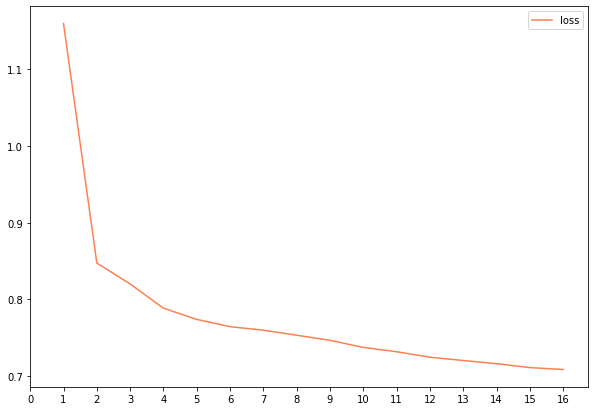

In [ ]:
plt.figure(figsize=(10, 7))
sns.lineplot(
    x=[epoch + 1 for epoch in range(len(train_state['train_loss']))],
    y=train_state['train_loss'],
    color='coral', 
    label='loss',
)

plt.xticks([epoch for epoch in range(len(train_state['train_loss']) + 1)])
plt.show()

In [ ]:
model.load_state_dict(torch.load(train_state['model_filename']))
model = model.to(args.device)
loss_func = torch.nn.MSELoss(reduction="sum")
dataset.set_split('test')

batch_generator = generate_batches(
    dataset, 
    batch_size=args.batch_size, 
    device=args.device,
    drop_last=False
)

model.eval()
model.encoder_only = True
predictions = []
targets = []

with torch.no_grad():
    for batch_index, batch_dict in enumerate(batch_generator):
        
        x = batch_dict['x_data']
        y_target = batch_dict['y_target']
        
        y_pred = model(x, None)
        for pred, target in zip(y_pred, y_target):
            predictions.append(pred.cpu().numpy().argmax())
            targets.append(target)

In [ ]:
for i, aspect in enumerate(model.get_aspect_words(w2v)):
    print(i, " ".join([a for a in aspect]))

0 спектакл театрын спектакль театр исемендә фестивал артист опера әкият сәхнәс
1 пычак җинаять законсыз полиция маддә тоткарлаган наркотик урлаган ялган хокук
2 спектакль билет опера театр премьера спектакл матч тамашач режиссер сезон
3 режиссер театр спектакл драма тренер театрын пьеса зәйниев мәктәб бикчәнтәев
4 бала матур әби кеш намаз апа өй кайт малай аллаһ
5 спорт ярыш ярышларын чаң беренчеле этаб республи этабын турнир данын
6 мөфти мөселман диния нәзарәт мәчет ураза исла шура хәзрәт аллаһ
7 сөт тонна терлек хуҗалы чәчү ашлык гектар центнер хуҗалык терлекчелек
8 көндәш период азеведо матч зенит гол очко команда хоккейчы командасын
9 башлы артист депутат тимергалиева хәмдүнә рәи рәхмәт җырч айрат шакиров
10 галим шигырь шәхес иҗатын язуч шагыйрь язучы әдәбият фән композитор
11 период урамында музе урамын урам янгын барс гасыр ак глухов
12 объект ферма булдыру бина технология корылма музей инфраструктура база төзү
13 конкурс грант ярминкә проект бәй номинация фору бәйг фестиваль к

In [ ]:
mapper_rev = {v: k for k, v in mapper.items()}

cluster_map_ABAE = {
    0: "culture",
    1: "incident",
    2: "culture",
    3: "culture",
    4: "religion",
    5: "sport",
    6: "religion",
    7: "agriculture",
    8: "sport",
    9: "culture",
    10: "culture",
    11: "culture",
    12: "agriculture",
    13: "culture",
    14: "incident",
}

y_pred = list(map(lambda x: mapper[x], [cluster_map_ABAE[pred] for pred in predictions]))
y_true = list(map(lambda x: x.item(), targets))

### Results

In [ ]:
print(classification_report(y_true, y_pred,
                            target_names=['culture', 'incident', 'sport',
                                          'agriculture', 'religion'],
                            digits=3))

              precision    recall  f1-score   support

     culture      0.872     0.893     0.883      1497
    incident      0.706     0.986     0.823      1314
       sport      0.927     0.486     0.638       654
 agriculture      0.856     0.825     0.840       589
    religion      0.872     0.522     0.653       559

    accuracy                          0.808      4613
   macro avg      0.847     0.742     0.767      4613
weighted avg      0.830     0.808     0.798      4613

